# Computing the distribution of mRNA using the solution of the chemical master equation for a two state promoter.

In [1]:
import glob
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
from sympy import mpmath
import pandas as pd
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import evolution_bits_utils as evo_utils

# Set PBoC plotting style
evo_utils.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

outputdir = '../../output/chemical_master_eq/'
figdir = '../../fig/chemical_master_analytic/'
tmpdir = '../../tmp'

#  Analytical solution of the chemical master equation for the two-state repressor mRNA distribution

[Sanchez and Kondev's paper](http://www.sciencedirect.com/science/article/pii/S1046202313000959) as well as [Shahrezaei and Swain](http://www.pnas.org/content/105/45/17256.short) present the analytical distribution for the mRNA copy number of a two-state promoter at steady state. We can list the possible "reactions" (state transitions in the Markovian chain) with their respective rates as
\begin{align}
\begin{array}{cc}
\text{reaction} & \text{rate}\\
\text{active} \rightarrow \text{inactive} & k_{off}\\
\text{inactive} \rightarrow \text{active} & k_{on}\\
m \rightarrow m+1 & r\\
m \rightarrow m-1 & m \cdot \gamma\\
\end{array}
\end{align}

With these states and transition rates we can write the distribution $P(m)$ where $ m $ is the number of mRNA molecules is given by
\begin{equation}
    P(m) = \frac{\Gamma \left( \frac{k_{on}}{\gamma} + m \right)}{\Gamma(m + 1) \Gamma\left( \frac{k_{off}+k_{on}}{\gamma} + m \right)} \frac{\Gamma\left( \frac{k_{off}+k_{on}}{\gamma} \right)}{\Gamma\left( \frac{k_{on}}{\gamma} \right)} \left( \frac{r}{\gamma} \right)^m F_1^1 \left( \frac{k_{on}}{\gamma} + m, \frac{k_{off} + k_{on}}{\gamma} + m, -\frac{r}{\gamma} \right),
\end{equation}
where $r$ is the production rate, $\gamma$ is the degradation rate, $k_{off}$ and $k_{on}$ are the transition rates between the inactive and the active state respectively and $\Gamma$ is the Gamma function.

The function $F^1_1$ is the so-called [confluent hypergeometric function of first kind](http://mathworld.wolfram.com/ConfluentHypergeometricFunctionoftheFirstKind.html) which is implemented in [SymPy](http://docs.sympy.org/0.7.1/modules/mpmath/functions/hypergeometric.html) and in [scipy](http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.hyp1f1.html#scipy.special.hyp1f1)

**It is important to clarify that there is some inconsistent nomenclature between Sanchez and Kondev's paper and Jones and Brewster's paper. For Sanchez (and for this distribution) $k_{on}$ represents the rate at which the promoters goes to the active state. For Brewster that rate is given by $k_{off}$. So that is important to keep in mind when extracting the parameters from these papers**

<!---
But to have anlytical progress we can use its integral representation given by
\begin{equation}
F^1_1(a; b; z) = \frac{\Gamma(b)}{\Gamma(b - a) \Gamma(a)} \int^1_0 \mathbf{e}^{z t} t^{a - 1} (1 - t)^{b - a - 1} dt
\end{equation}
-->

Numerically it is better to use the log of the probability to facilitate the computation. Since scipy has a special function to compute the log of the gamma function we can express $ \ln P(m \mid C, R)$ as
\begin{equation}
    \ln P(m \mid C, R) = \ln \Gamma \left( \frac{k_{on}}{\gamma} + m \right)
    - \ln \Gamma \left( m + 1 \right)
    - \ln \Gamma \left( \frac{k_{off} + k_{on}}{\gamma} + m \right)
    + \ln \Gamma \left( \frac{k_{off} + k_{on}}{\gamma} \right)
    - \ln \Gamma \left( \frac{k_{on}}{\gamma} \right)
    + m \ln \left( \frac{r}{\gamma} \right)
    + \ln F^1_1 \left( \frac{k_{on}}{\gamma} + m, 
    \frac{k_{off} + k_{on}}{\gamma} + m, 
    -\frac{r}{\gamma} \right)
\end{equation}

### Including the effect of the inducer (lactose) in the model.

In order to compute the joint probability distribution of the gene expression level  given a substrate concentration $ C $ we will use the MWC model in the following way:
Since $k_{off}$ is a function of the number of **active** number of repressors (i.e. able to bind the DNA), we can multiply this rate by the probability of the repressors being active $p_{act}$ which would tell us the fraction of repressors that are in the active state on average.
For the *lac* repressor this probability is given by
\begin{equation}
    p_{act}(C) = \frac{\left(1 + \frac{C}{K_A} \right)^2}{\left(1 + \frac{C}{K_A} \right)^2 + \omega \left(1 + \frac{C}{K_I} \right)^2}
\end{equation}
where all the parameters were determined in Tal's project.

This means that the conditional probability we are looking for is given by
\begin{equation}
 P(m \mid C, R) = P \left(m \mid k_{off} = k_0 \cdot R \cdot p_{act}(C)\right)
\end{equation}

Now we can define the function to compute the log conditional probability
\begin{align}
    \ln P(m \mid C, R)
\end{align}

In [2]:
# define a np.frompyfunc that allows us to evaluate the sympy.mp.math.hyp1f1
np_log_hyp= np.frompyfunc(lambda x, y, z: \
mpmath.ln(mpmath.hyp1f1(x, y, z, zeroprec=1000)), 3, 1)

def log_p_m_mid_C(C, mRNA, rep, ki, ka, epsilon, kon, k0, gamma, r_gamma,
                 logC=False):
    '''
    Computes the log conditional probability lnP(m|C,R), 
    i.e. the probability of having m mRNA molecules given 
    an inducer concentration C and a repressor copy number R.
    
    Parameters
    ----------
    C : float.
        Concentration at which evaluate the probability. if logC=True, then
        this array is defined as log10(C).
    mRNA : float.
        mRNA copy number at which evaluate the probability.        
    repressor : float.
        repressor copy number per cell.
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
    kon : float.
        rate of activation of the promoter in the chemical master equation
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    gamma : float.
        half-life time for the mRNA.
    r_gamma : float.
        average number of mRNA in the unregulated promoter.
    logC : Bool.
        boolean indicating if the concentration is given in log scale
    
    Returns
    -------
    log probability lnP(m|c,R)
    '''
    # Convert C and mRNA into np.arrays
    C = np.array(C)
    mRNA = np.array(mRNA)
    if logC:
        C = 10**C
    
    # Calculate the off rate including the MWC model
    koff = k0 * rep * evo_utils.p_act(C, ka, ki, epsilon)

    # Compute the probability
    lnp = scipy.special.gammaln(kon / gamma + mRNA) \
    - scipy.special.gammaln(mRNA + 1) \
    - scipy.special.gammaln((koff + kon) / gamma + mRNA) \
    + scipy.special.gammaln((koff + kon) / gamma) \
    - scipy.special.gammaln(kon / gamma) \
    + mRNA * np.log(r_gamma) \
    + np_log_hyp(kon / gamma + mRNA,
            (koff + kon) / gamma + mRNA, -r_gamma)
    
    return lnp.astype(float)

# Determining the parameters for the function.

Let's compile all the parameters I think are true for this function to reproduce experimental results.

As mentioned above the parameter $k_{off}$ is given by a diffusion-limited rate $k_0$ times the concentration of active repressors $[R_{act}] = [R] \cdot p_{act}$. [Jones & Brewster](http://science.sciencemag.org/content/346/6216/1533)'s paper report using a value of
\begin{equation}
k_0 = 2.7 \times 10^{-3} (\text{s nM})^{-1},
\end{equation}
where to convert from repressor copy number to concentration we will use an *E. coli* volume of *1 fL*.

For the $k_{on}$ parameter we can use the fact that the mean of this distribution is given by
\begin{equation}
\left\langle m \right\rangle = \frac{r}{\gamma} \frac{k_{on}}{k_{on} + k_{off}}.
\end{equation}

When computing the fold-change with respect to the $\Delta lacI$ strain where  $k_{off} = 0$ we find that
\begin{align}
\text{fold-change} &= \frac{k_{on}}{k_{on} + k_{off}}\\
&= \frac{k_{on}}{k_{on} + k_0 \cdot p_{act} \cdot [R]}\\
&= \frac{1}{1 + \frac{k_0 \cdot p_{act} \cdot [R]}{k_{on}}}.
\end{align}

This last functional form of the fold-change is completely analogous to the one determined by [Garcia & Phillips](http://www.pnas.org/content/108/29/12173.short) using the language of statistical mechanics to compute the mean fold change
\begin{equation}
\text{fold-change} = \frac{1}{1 + \frac{2R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r}},
\end{equation}
where $R$ is the absolute copy number of repressors per cell, $N_{NS}$ is the number of non-specific binding sites for the repressors (in our case the entire *E. coli genome* $4.6 \times 10^6$), $\beta$ is the inverse temperature times the Boltzmann constant and $\Delta \epsilon_r$ is the binding energy of the repressor to the operator binding site. Our equation is different from the one used in the paper since we include the factor $p_{act}$ to account for the number of active repressors in the cell.

Equating both of this expressions and solving for $k_{on}$ we obtain
\begin{equation}
k_{on} = \frac{k_0 \cdot [R] \cdot N_{NS}}{2R}e^{\beta \Delta \epsilon_r}.
\end{equation}
For the units to cancel out properly the repressor concentration has to be given in nM. If we consider that the repressor concentration is equal to
\begin{equation}
[R] = \frac{R}{V_{cell}}\cdot \frac{1}{Av},
\end{equation}
where $R$ is the absolute repressor copy number per cell, $V_{cell}$ is the cell volume and $Av$ is Avogadro's number. We said that the cell volume is in the order of 1 fL = $10^{-15}$ L, and Avogadro's number is $6.022 \times 10^{23}$. if we further include the conversion factor to turn M into nM we find that
\begin{equation}
[R] = \frac{R}{10^{-15}L}\cdot \frac{1}{6.022 \times 10^{23}} \cdot \frac{10^9 nmol}{1 mol},
\end{equation}
which is equal to

In [3]:
1E15 * 1E9 / 6.022E23

1.6605778811026237

Therefore we conclude that $[R] \approx 1.66 \times R$. This gives
\begin{equation}
k_{on} = \frac{1.66}{2} k_0 \cdot N_{NS} e^{\beta \Delta \epsilon_r}.
\end{equation}
Computing the values for the known operators we find

In [4]:
# Define a simple lambda function to compute kon as a function of the binding
# energy
kon_fn = lambda epsilon, k0: 1.66 / 2 * k0 * 4.6E6 * np.exp(epsilon)
k0 = 2.7E-3
kon_array = [kon_fn(-17, k0), kon_fn(-15.3, k0),
             kon_fn(-13.9, k0), kon_fn(-9.7, k0)]

print("""
k_on values for the 4 operators
-------------------------------
k_on Oid : {0:.5f} s^-1
k_on O1  : {1:.4f} s^-1
k_on O2  : {2:.3f} s^-1
k_on O3  : {3:.3f} s^-1
""".format(kon_array[0], kon_array[1], kon_array[2], kon_array[3]))


k_on values for the 4 operators
-------------------------------
k_on Oid : 0.00043 s^-1
k_on O1  : 0.0023 s^-1
k_on O2  : 0.009 s^-1
k_on O3  : 0.632 s^-1



For the $\frac{r}{\gamma}$ parameter Jones & Brewster report having measured for the *LacUV5* promoter a mean copy number of *15.7 mRNA per cell*. For the parameter $\gamma$ we will use [this value](http://bionumbers.hms.harvard.edu/bionumber.aspx?&id=107514&ver=1&trm=mean%20mrna%20life%20e%20coli) from bionumbers of 352 seconds for the mean life.

As it is today the parameters for the MWC model are note entirely determined. For now we will use some preliminary values
\begin{align}
\Delta\varepsilon_{AI} &= 4.5\\
K_A &= 0.21 mM\\
K_I &= 0.00087 mM
\end{align}

# Testing the function with these parameters
Now lets plot this function with the parameters given in Daniel and Brewster's Science paper using the values for $O1$

In [13]:
# Specify some parameters
k0 = 2.7E-3
params = dict(ka=0.21, ki=0.00087, epsilon=4.5, kon=kon_fn(-13.9, k0),
              k0=k0, gamma=0.00284, r_gamma=15.7)

Compute the probability distributions for different repressor copy numbers

In [14]:
# Define the range of m on which evaluate the function
m_grid = np.arange(0,30)

# Define the repressor copy number for which evaluate the function
R_array = [0, 11, 130, 870]

# Compute the conditional probability for ech repressor copy number
p_mC_mat = np.empty([len(R_array), len(m_grid)])
# Define the colors for the plot
colors = sns.color_palette('Blues_r', len(R_array) + 1)[:-1]

for i, r in enumerate(R_array):
    params['kon'] = evo_utils.kon_fn(-9.7, k0)
    p_mC_mat[i, :] = np.exp(log_p_m_mid_C(C=0, mRNA=m_grid, 
                                          rep=r * 1.66, **params))

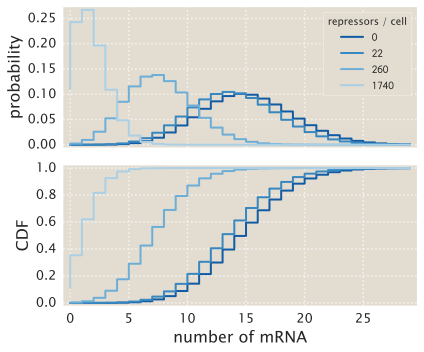

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(6,5), sharex=True)
for i, R in enumerate(R_array):
    ax[0].plot(m_grid, p_mC_mat[i, :],
             label=r'${0:0.0f}$'.format(R * 2), drawstyle='steps',
              color=colors[i])
    ax[1].plot(m_grid, np.cumsum(p_mC_mat[i, :]), drawstyle='steps',
              color=colors[i])

ax[0].legend(loc=0, title='repressors / cell')
ax[0].set_ylabel('probability')
ax[0].margins(0.02)

ax[1].set_xlabel('number of mRNA')
ax[1].set_ylabel('CDF')
ax[1].margins(0.02)

plt.tight_layout()
plt.savefig(figdir + 'mRNA_dist_O3.pdf')

## Testing the effect of the inducer

As a test let's also plot for different number of repressors the mRNA distribution at different inducer concentrations.

In [12]:
# Specify some parameters
k0 = 2.7E-3
params = dict(ka=0.21, ki=0.00087, omega=np.exp(-4.5), kon=kon_fn(-9.7, k0),
              k0=k0, gamma=0.00284, r_gamma=15.7)

Compute the probability distributions for different inducer concentrations

In [16]:
# Define the range of m on which evaluate the function
m_grid = np.arange(0,30)

# Define the concentrations to test
concentrations = [0, 10, 50, 100, 500] # uM IPTG

# Compute the conditional probability for ech repressor copy number
p_mC_mat = np.empty([len(concentrations), len(m_grid)])
for i, c in enumerate(concentrations):
    p_mC_mat[i, :] = np.exp(log_p_m_mid_C(C=c / 1E3, mRNA=m_grid, 
                                          rep=130 * 1.66, **params))

/Users/razo/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


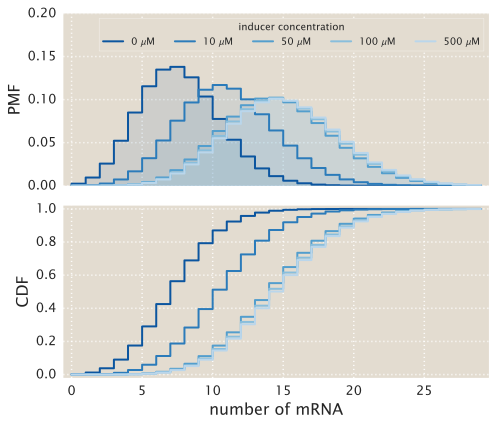

In [33]:
# Define the colors for the plot
colors = sns.color_palette('Blues_r', len(concentrations) + 1)[:-1]

fig, ax = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
for i, c in enumerate(concentrations):
    # Plot the PMF
    ax[0].plot(m_grid, p_mC_mat[i, :],
             label=r'{0:0.0f} $\mu$M'.format(c), drawstyle='steps',
              color=colors[i])
    ax[0].fill_between(m_grid, p_mC_mat[i, :], color=colors[i], alpha=0.1,
                      step='pre')
    # Plot the CDF
    ax[1].plot(m_grid, np.cumsum(p_mC_mat[i, :]), drawstyle='steps',
              color=colors[i])

ax[0].legend(loc=0, title='inducer concentration', ncol=5, fontsize=10)
ax[0].set_ylabel('PMF')
ax[0].set_ylim(top=0.2)
ax[0].margins(0.02)

ax[1].legend(loc=0)
ax[1].set_xlabel('number of mRNA')
ax[1].set_ylabel('CDF')
ax[1].margins(0.02)

plt.tight_layout()
plt.savefig(figdir + 'mRNA_dist_IPTG_RBS1027_O3.pdf')

## Reproducing the lacI titration curves with the chemical master equation.

As a simple sanity check it is important to confirm that the chemical master equation is indeed reproducing the "golden-standard" lacI titration curves from Hernan's PNAS paper.

What we need to do to reproduce this is to compute the full distribution as a function of the repressor copy number and then obtain the mean expression level by simply computing
\begin{equation}
\left\langle m \right\rangle = \sum_m P(m) \cdot m.
\end{equation}
Then we divide this mean expression level by the mean expression level of the strain with $R = 0$ to compute the fold change.

In [21]:
# Define the repressor and mRNA array
R_array = np.logspace(0, 3, 100)
mRNA_grid = np.arange(0, 50)

# Define array with operators binding energies
operators = [-17, -15.3, -13.9, -9.7]
# Define a quick Lambda function to compute Hernan's fold change
fc_fn = lambda R, epsilon : 1 / (1 + 2 * R / 4.6E6 * np.exp(-epsilon))

k0 = 2.7E-3
params = dict(ka=0.21, ki=0.00087, epsilon=4.5, kon=kon_fn(-15.3, k0),
              k0=k0, gamma=0.00284, r_gamma=15.7)

# Compute the mean expression of the delta strain
dist_delta = np.exp(log_p_m_mid_C(C=0, mRNA=m_grid, rep=0, **params))
mean_m_delta = np.sum(m_grid * dist_delta)

# Iinitialize the array to save the fold-changes
fc_chem_master = np.zeros([len(operators), len(R_array)])
fc_stat_mech = np.zeros([len(operators), len(R_array)])
#loop through operators and repressors
for i, o in enumerate(operators):
    params['kon'] = kon_fn(o, k0)
    for j, r in enumerate(R_array):
        # compute the distribution. The factor of 1.66 is to convert from
        # absolute copy number to nM concentrations.
        dist = np.exp(log_p_m_mid_C(C=0, mRNA=m_grid, rep=r * 1.66, **params))
        # from the distribution obtain the mean
        mean_m = np.sum(m_grid * dist)
        # compute the fold change with respect to the ∆lacI strain
        fc_chem_master[i, j] = mean_m / mean_m_delta
        fc_stat_mech[i, j] = fc_fn(r, o)

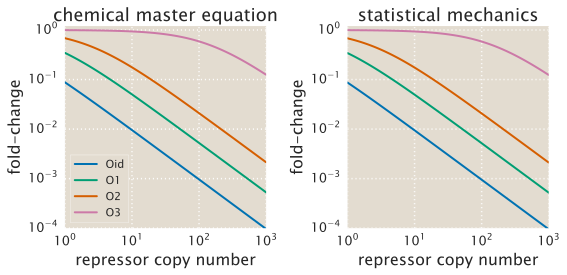

In [22]:
operators_name = ['Oid', 'O1', 'O2', 'O3']
# Plot the results of both theories
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, o in enumerate(operators):
    ax[0].plot(R_array, fc_chem_master[i,:],
              label=operators_name[i])
    ax[1].plot(R_array, fc_stat_mech[i,:],
              label=operators_name[i])
# Format the plots
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('repressor copy number')
ax[0].set_ylabel('fold-change')
ax[0].set_title('chemical master equation')
ax[0].legend(loc='lower left')
ax[0].set_ylim([1E-4, 1.2])

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('repressor copy number')
ax[1].set_ylabel('fold-change')
ax[1].set_title('statistical mechanics')
ax[1].set_ylim([1E-4, 1.2])
plt.tight_layout()
plt.savefig(figdir + 'CME_statmech_comparison.pdf')

The curves look exactly the same. That means that by design our selected parameters are indeed in agreement with the previous work from the lab.

### Comparison with the parameters used by Jones, Brewster and Phillips, Science 2014

In [23]:
# Define the repressor and mRNA array
R_array = np.logspace(0, 3, 100)
mRNA_grid = np.arange(0, 50)

# Define array with operators binding energies
operators = [-17, -15.3, -13.9, -9.7]
# Define array with Jones and Brewster's kon values (koff in their nomenclature)
kon_array = [0.0023, 0.0069, 0.091, 2.1]
# Define a quick Lambda function to compute Hernan's fold change
fc_fn = lambda R, epsilon : 1 / (1 + 2 * R / 4.6E6 * np.exp(-epsilon))

k0 = 2.7E-3
params = dict(ka=0.21, ki=0.00087, epsilon=4.5, kon=kon_fn(-15.3, k0),
              k0=k0, gamma=0.00284, r_gamma=15.7)

# Compute the mean expression of the delta strain
dist_delta = np.exp(log_p_m_mid_C(C=0, mRNA=m_grid, rep=0, **params))
mean_m_delta = np.sum(m_grid * dist_delta)

# Iinitialize the array to save the fold-changes
fc_chem_master = np.zeros([len(operators), len(R_array)])
fc_stat_mech = np.zeros([len(operators), len(R_array)])

#loop through operators and repressors
for i, o in enumerate(operators):
    params['kon'] = kon_array[i]
    for j, r in enumerate(R_array):
        # compute the distribution. The factor of 1.66 is to convert from
        # absolute copy number to nM concentrations.
        dist = np.exp(log_p_m_mid_C(C=0, mRNA=m_grid, rep=r * 1.66, **params))
        # from the distribution obtain the mean
        mean_m = np.sum(m_grid * dist)
        # compute the fold change with respect to the ∆lacI strain
        fc_chem_master[i, j] = mean_m / mean_m_delta
        fc_stat_mech[i, j] = fc_fn(r, o)

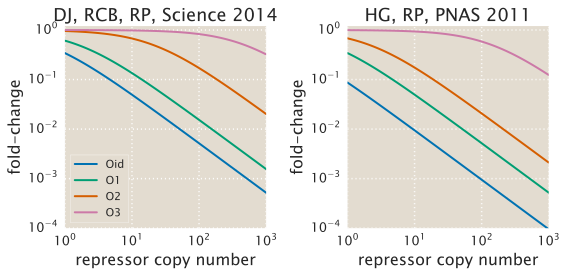

In [24]:
operators_name = ['Oid', 'O1', 'O2', 'O3']
# Plot the results of both theories
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, o in enumerate(operators):
    ax[0].plot(R_array, fc_chem_master[i,:],
              label=operators_name[i])
    ax[1].plot(R_array, fc_stat_mech[i,:],
              label=operators_name[i])
# Format the plots
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('repressor copy number')
ax[0].set_ylabel('fold-change')
ax[0].set_title('DJ, RCB, RP, Science 2014')
ax[0].legend(loc='lower left')
ax[0].set_ylim([1E-4, 1.2])

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('repressor copy number')
ax[1].set_ylabel('fold-change')
ax[1].set_title('HG, RP, PNAS 2011')
ax[1].set_ylim([1E-4, 1.2])
plt.tight_layout()
plt.savefig(figdir + 'CME_statmech_comparison_DJ_RCB.pdf')

Suprisingly the parameters that Brewster, Jones and Phillips report on their Science, 2014 paper are not consistent with the statistical mechanics framework. The way they determined the $k_{off}$ parameter was by using an *in-vitro* measurement of this parameter using Oid and then they used Hernan's binding energies to take the ratio between the dissociation constants (calculated from the binding energies) and assumed that this was the same as the ratio of the rate constants.